# Combined Audio-Visual Feature Classification

This notebook combines visual and audio features for multi-modal character classification.
It relies on cached feature files generated by:
- `1_video.ipynb` → `visual_features.npz`
- `2_audio.ipynb` → `audio_features.npz`

In [1]:
import os, glob, warnings
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GroupShuffleSplit
from sklearn.preprocessing import StandardScaler, LabelEncoder, label_binarize
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings("ignore")

In [2]:
# Configuration
DATA_DIR = "./data"
VISUAL_CACHE = os.path.join(DATA_DIR, "visual_features.npz")
AUDIO_CACHE = os.path.join(DATA_DIR, "audio_features.npz")

SEED = 12332287
CLASSES = ["MissPiggy", "OtherPigs", "SwedishChef", "Rowlf"]

np.random.seed(SEED)

## Load Cached Features

In [3]:
# Check cache files exist
if not os.path.exists(VISUAL_CACHE):
    raise FileNotFoundError(f"Visual features cache not found: {VISUAL_CACHE}\nPlease run 1_video.ipynb first.")

if not os.path.exists(AUDIO_CACHE):
    raise FileNotFoundError(f"Audio features cache not found: {AUDIO_CACHE}\nPlease run 2_audio.ipynb first.")

print("Both cache files found. Loading...")

Both cache files found. Loading...


In [4]:
# Load visual features
print("Loading visual features...")
with np.load(VISUAL_CACHE) as data:
    X_hog_frames = data['X_hog_frames']
    X_lbp_frames = data['X_lbp_frames']
    X_glcm_frames = data['X_glcm_frames']
    X_sift_frames = data['X_sift_frames']
    y_labels_visual = data['y_labels']
    video_ids_visual = data['video_ids_per_frame']

print(f"  HOG: {X_hog_frames.shape}")
print(f"  LBP: {X_lbp_frames.shape}")
print(f"  GLCM: {X_glcm_frames.shape}")
print(f"  SIFT: {X_sift_frames.shape}")
print(f"  Labels: {len(y_labels_visual)}")

Loading visual features...
  HOG: (29394, 8100)
  LBP: (29394, 10)
  GLCM: (29394, 2)
  SIFT: (29394, 128)
  Labels: 29394


In [5]:
# Load audio features
print("\nLoading audio features...")
with np.load(AUDIO_CACHE) as data:
    X_mfcc_frames = data['X_mfcc_frames']
    X_spec_frames = data['X_spec_frames']
    X_chroma_frames = data['X_chroma_frames']
    X_flux_frames = data['X_flux_frames']
    y_labels_audio = data['y_labels']
    video_ids_audio = data['video_ids_per_frame']

print(f"  MFCC: {X_mfcc_frames.shape}")
print(f"  Spectral: {X_spec_frames.shape}")
print(f"  Chroma: {X_chroma_frames.shape}")
print(f"  Flux: {X_flux_frames.shape}")
print(f"  Labels: {len(y_labels_audio)}")


Loading audio features...
  MFCC: (29394, 20)
  Spectral: (29394, 9)
  Chroma: (29394, 12)
  Flux: (29394, 1)
  Labels: 29394


In [6]:
# Verify alignment
assert len(y_labels_visual) == len(y_labels_audio), "Visual and audio feature counts don't match!"
assert np.array_equal(y_labels_visual, y_labels_audio), "Labels don't match between visual and audio!"
assert np.array_equal(video_ids_visual, video_ids_audio), "Video IDs don't match between visual and audio!"

y_labels = y_labels_visual
video_ids_per_frame = video_ids_visual

print(f"\n✓ Alignment verified: {len(y_labels)} samples")


✓ Alignment verified: 29394 samples


## Build Feature Datasets

In [7]:
# Visual dataset (HOG + LBP + SIFT, excluding GLCM due to lower performance)
ds_visual = np.hstack((X_hog_frames, X_lbp_frames, X_sift_frames))
print(f"Visual dataset shape: {ds_visual.shape}")

# Audio dataset (MFCC + Spectral + Chroma, excluding Flux due to lower performance)
ds_audio = np.hstack((X_mfcc_frames, X_spec_frames, X_chroma_frames))
print(f"Audio dataset shape: {ds_audio.shape}")

# Combined dataset
ds_combined = np.hstack((ds_visual, ds_audio))
print(f"Combined dataset shape: {ds_combined.shape}")

Visual dataset shape: (29394, 8238)
Audio dataset shape: (29394, 41)
Combined dataset shape: (29394, 8279)


In [8]:
# Feature dimensionality summary
print("\n" + "="*60)
print("FEATURE DIMENSIONALITY SUMMARY")
print("="*60)
print("\nVISUAL FEATURES:")
print(f"  HOG:   {X_hog_frames.shape[1]:>6} dimensions")
print(f"  LBP:   {X_lbp_frames.shape[1]:>6} dimensions")
print(f"  SIFT:  {X_sift_frames.shape[1]:>6} dimensions")
print(f"  ----------------------")
print(f"  Total: {ds_visual.shape[1]:>6} dimensions")

print("\nAUDIO FEATURES:")
print(f"  MFCC:     {X_mfcc_frames.shape[1]:>6} dimensions")
print(f"  Spectral: {X_spec_frames.shape[1]:>6} dimensions")
print(f"  Chroma:   {X_chroma_frames.shape[1]:>6} dimensions")
print(f"  ----------------------")
print(f"  Total:    {ds_audio.shape[1]:>6} dimensions")

print("\nCOMBINED:")
print(f"  Visual + Audio: {ds_combined.shape[1]} dimensions")
print("="*60)


FEATURE DIMENSIONALITY SUMMARY

VISUAL FEATURES:
  HOG:     8100 dimensions
  LBP:       10 dimensions
  SIFT:     128 dimensions
  ----------------------
  Total:   8238 dimensions

AUDIO FEATURES:
  MFCC:         20 dimensions
  Spectral:      9 dimensions
  Chroma:       12 dimensions
  ----------------------
  Total:        41 dimensions

COMBINED:
  Visual + Audio: 8279 dimensions


## Data Splitting

In [9]:
def get_train_test_indices(groups, test_size=0.2, random_state=SEED):
    """Splits data so that all frames from one video are EITHER in train OR test."""
    gss = GroupShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)
    train_idx, test_idx = next(gss.split(X=groups, y=groups, groups=groups))
    return train_idx, test_idx


def scale_train_test(X_train, X_test):
    scaler = StandardScaler()
    X_train_s = scaler.fit_transform(X_train)
    X_test_s = scaler.transform(X_test)
    return X_train_s, X_test_s

In [10]:
# Encode labels
label_encoder = LabelEncoder()
y_all_enc = label_encoder.fit_transform(y_labels)

# Get train/test indices (group by video to avoid data leakage)
idx_train, idx_test = get_train_test_indices(video_ids_per_frame)

y_train_enc = y_all_enc[idx_train]
y_test_enc = y_all_enc[idx_test]

print(f"Training samples: {len(idx_train)}")
print(f"Test samples: {len(idx_test)}")
print(f"\nClass distribution in training set:")
for cls_idx, cls_name in enumerate(label_encoder.classes_):
    count = (y_train_enc == cls_idx).sum()
    print(f"  {cls_name}: {count}")

Training samples: 22788
Test samples: 6606

Class distribution in training set:
  MissPiggy: 7847
  OtherPigs: 11749
  Rowlf: 1918
  SwedishChef: 1274


In [11]:
# Split and scale all feature sets
ds_visual_train, ds_visual_test = ds_visual[idx_train], ds_visual[idx_test]
ds_audio_train, ds_audio_test = ds_audio[idx_train], ds_audio[idx_test]
ds_combined_train, ds_combined_test = ds_combined[idx_train], ds_combined[idx_test]

ds_visual_train_s, ds_visual_test_s = scale_train_test(ds_visual_train, ds_visual_test)
ds_audio_train_s, ds_audio_test_s = scale_train_test(ds_audio_train, ds_audio_test)
ds_combined_train_s, ds_combined_test_s = scale_train_test(ds_combined_train, ds_combined_test)

print("Feature sets scaled and ready.")

Feature sets scaled and ready.


## Feature Space Visualization

In [12]:
def plot_pca_comparison(datasets, titles, y, sample_size=2000):
    """Plot PCA visualization for multiple feature sets side by side."""
    fig, axes = plt.subplots(1, len(datasets), figsize=(6*len(datasets), 5))
    
    # Sample for faster plotting
    if len(y) > sample_size:
        subset_idx = np.random.choice(len(y), sample_size, replace=False)
    else:
        subset_idx = np.arange(len(y))
    
    y_subset = y[subset_idx]
    
    for ax, (X, title) in zip(axes, zip(datasets, titles)):
        X_subset = X[subset_idx]
        
        pca = PCA(n_components=2)
        X_pca = pca.fit_transform(X_subset)
        
        df_pca = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])
        df_pca['Label'] = y_subset
        
        sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='Label', 
                        alpha=0.5, palette='Set1', ax=ax, legend=(ax == axes[-1]))
        ax.set_title(title, fontsize=12, fontweight='bold')
        ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
        ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
        ax.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()

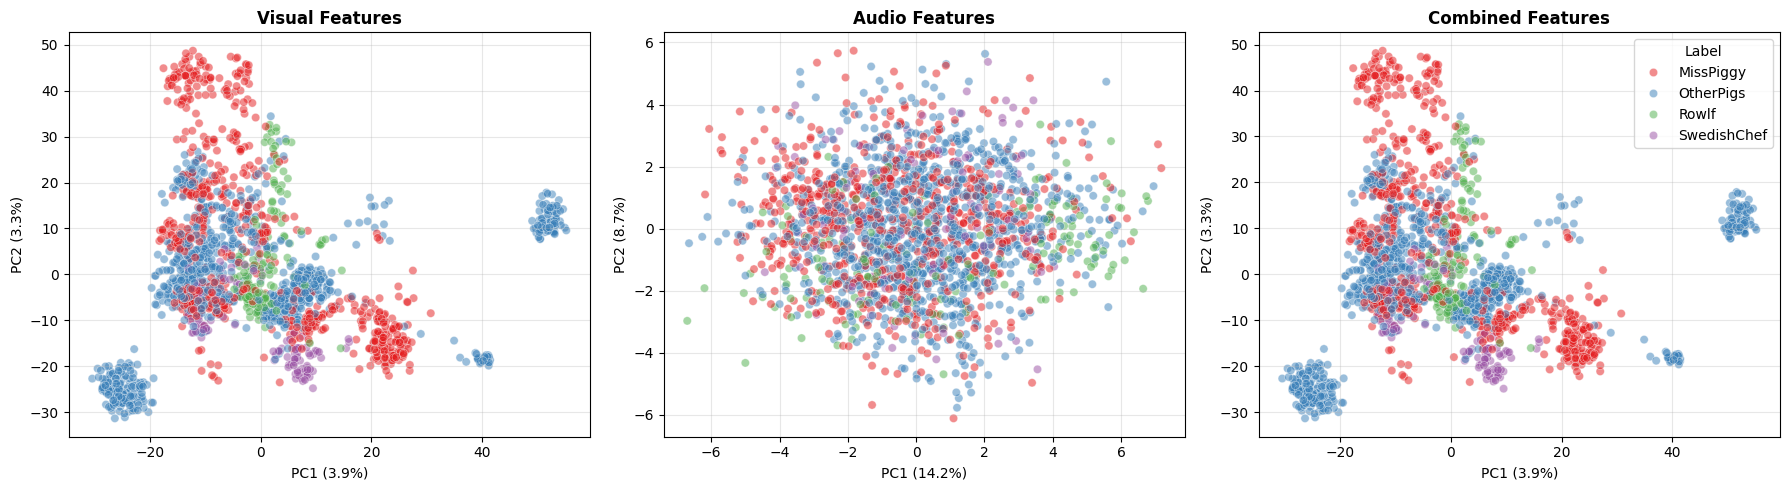

In [13]:
plot_pca_comparison(
    [ds_visual_train_s, ds_audio_train_s, ds_combined_train_s],
    ['Visual Features', 'Audio Features', 'Combined Features'],
    y_labels[idx_train]
)

## Classification

We'll compare three classifiers (MLP, SVM, Random Forest) across three feature sets (Visual, Audio, Combined).

In [14]:
# Store results for comparison
results = []

feature_sets = {
    'Visual': (ds_visual_train_s, ds_visual_test_s),
    'Audio': (ds_audio_train_s, ds_audio_test_s),
    'Combined': (ds_combined_train_s, ds_combined_test_s),
}

### MLP Classifier

In [15]:
print("="*50)
print("MLP Classifier")
print("="*50)

mlp_models = {}

for feat_name, (X_train, X_test) in feature_sets.items():
    cls_mlp = MLPClassifier(
        hidden_layer_sizes=(64,),
        max_iter=200,
        early_stopping=True,
        random_state=SEED
    )
    cls_mlp.fit(X_train, y_train_enc)
    pred = cls_mlp.predict(X_test)
    f1 = f1_score(y_test_enc, pred, average="macro")
    
    print(f"[{feat_name}] + [MLP] -> F1-Score: {f1:.4f}")
    results.append({'Feature': feat_name, 'Classifier': 'MLP', 'F1': f1})
    mlp_models[feat_name] = cls_mlp

MLP Classifier
[Visual] + [MLP] -> F1-Score: 0.3845
[Audio] + [MLP] -> F1-Score: 0.1761
[Combined] + [MLP] -> F1-Score: 0.4995


### SVM Classifier

In [16]:
print("\n" + "="*50)
print("SVM Classifier")
print("="*50)

svm_models = {}

for feat_name, (X_train, X_test) in feature_sets.items():
    cls_svm = SVC(kernel="rbf", C=10.0, gamma="scale", random_state=SEED)
    cls_svm.fit(X_train, y_train_enc)
    pred = cls_svm.predict(X_test)
    f1 = f1_score(y_test_enc, pred, average="macro")
    
    print(f"[{feat_name}] + [SVM] -> F1-Score: {f1:.4f}")
    results.append({'Feature': feat_name, 'Classifier': 'SVM', 'F1': f1})
    svm_models[feat_name] = cls_svm


SVM Classifier
[Visual] + [SVM] -> F1-Score: 0.1499
[Audio] + [SVM] -> F1-Score: 0.1919
[Combined] + [SVM] -> F1-Score: 0.1494


### Random Forest Classifier

In [17]:
print("\n" + "="*50)
print("Random Forest Classifier")
print("="*50)

rf_models = {}

for feat_name, (X_train, X_test) in feature_sets.items():
    cls_rf = RandomForestClassifier(n_estimators=200, random_state=SEED, n_jobs=-1)
    cls_rf.fit(X_train, y_train_enc)
    pred = cls_rf.predict(X_test)
    f1 = f1_score(y_test_enc, pred, average="macro")
    
    print(f"[{feat_name}] + [RF] -> F1-Score: {f1:.4f}")
    results.append({'Feature': feat_name, 'Classifier': 'RF', 'F1': f1})
    rf_models[feat_name] = cls_rf


Random Forest Classifier


python(57966) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


[Visual] + [RF] -> F1-Score: 0.1250
[Audio] + [RF] -> F1-Score: 0.1450
[Combined] + [RF] -> F1-Score: 0.1193


## Results Comparison

In [18]:
# Create results DataFrame
df_results = pd.DataFrame(results)
df_pivot = df_results.pivot(index='Feature', columns='Classifier', values='F1')
df_pivot = df_pivot[['MLP', 'SVM', 'RF']]  # Reorder columns

print("\n" + "="*60)
print("RESULTS SUMMARY (F1-Score)")
print("="*60)
print(df_pivot.to_string())
print("="*60)


RESULTS SUMMARY (F1-Score)
Classifier       MLP       SVM        RF
Feature                                 
Audio       0.176140  0.191935  0.144970
Combined    0.499508  0.149382  0.119271
Visual      0.384454  0.149873  0.125008


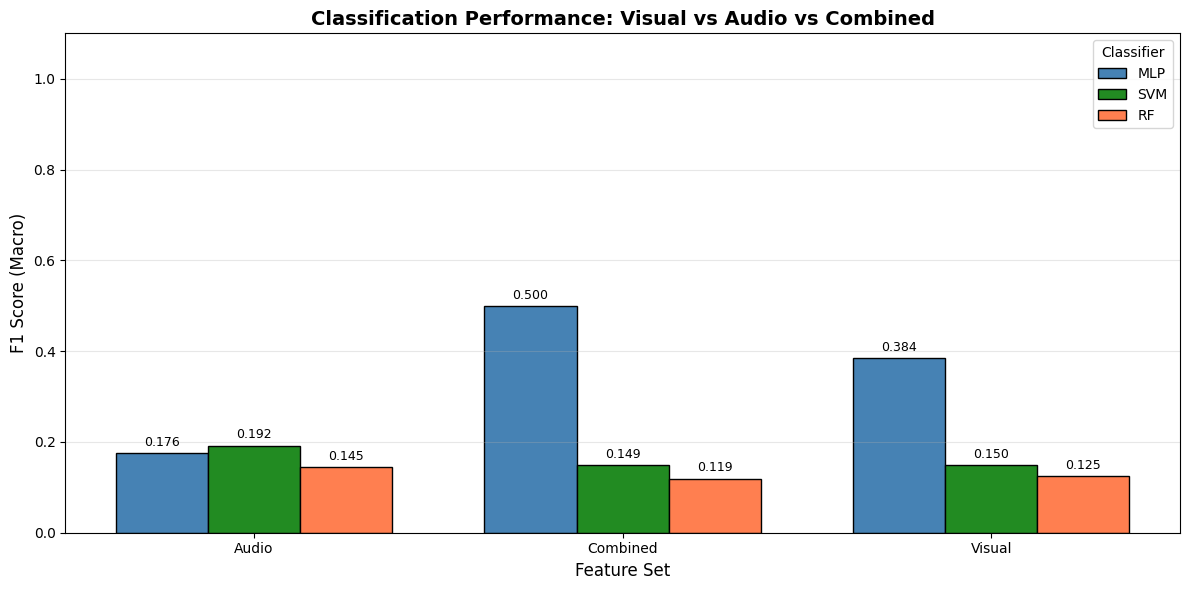

In [19]:
# Visualize results
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(df_pivot.index))
width = 0.25

colors = ['steelblue', 'forestgreen', 'coral']
for i, (classifier, color) in enumerate(zip(df_pivot.columns, colors)):
    bars = ax.bar(x + i*width, df_pivot[classifier], width, label=classifier, color=color, edgecolor='black')
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=9)

ax.set_xlabel('Feature Set', fontsize=12)
ax.set_ylabel('F1 Score (Macro)', fontsize=12)
ax.set_title('Classification Performance: Visual vs Audio vs Combined', fontsize=14, fontweight='bold')
ax.set_xticks(x + width)
ax.set_xticklabels(df_pivot.index)
ax.legend(title='Classifier')
ax.set_ylim(0, 1.1)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

In [27]:
# Find best combination
best_idx = df_results['F1'].idxmax()
best_result = df_results.loc[best_idx]
print(f"\nBest Performance: [{best_result['Feature']}] + [{best_result['Classifier']}] = F1: {best_result['F1']:.4f}")


Best Performance: [Combined] + [MLP] = F1: 0.4995


## Evaluation

In [21]:
def plot_multiclass_roc(models_dict, X_test, y_test, classes):
    """
    Plot ROC curves for multiple models and multiple classes.
    """
    n_classes = len(classes)
    y_test_bin = label_binarize(y_test, classes=range(n_classes))
    
    fig, axes = plt.subplots(1, n_classes, figsize=(5 * n_classes, 5))
    if n_classes == 1: 
        axes = [axes]
    
    colors = ['blue', 'green', 'red', 'orange', 'purple']
    
    for i, class_name in enumerate(classes):
        ax = axes[i]
        
        for model_idx, (model_name, model) in enumerate(models_dict.items()):
            color = colors[model_idx % len(colors)]
            
            try:
                if hasattr(model, "decision_function"):
                    y_score = model.decision_function(X_test)
                else:
                    y_score = model.predict_proba(X_test)
                
                if y_score.ndim > 1:
                    y_score_class = y_score[:, i]
                else:
                    y_score_class = y_score
            except AttributeError:
                print(f"Warning: {model_name} failed to produce scores.")
                continue
            
            fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score_class)
            roc_auc = auc(fpr, tpr)
            
            ax.plot(fpr, tpr, lw=2, color=color,
                    label=f'{model_name} (AUC = {roc_auc:.2f})')
        
        ax.plot([0, 1], [0, 1], 'k--', lw=1)
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title(f'ROC: {class_name}')
        ax.legend(loc="lower right")
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

ROC Curves for Combined Features:


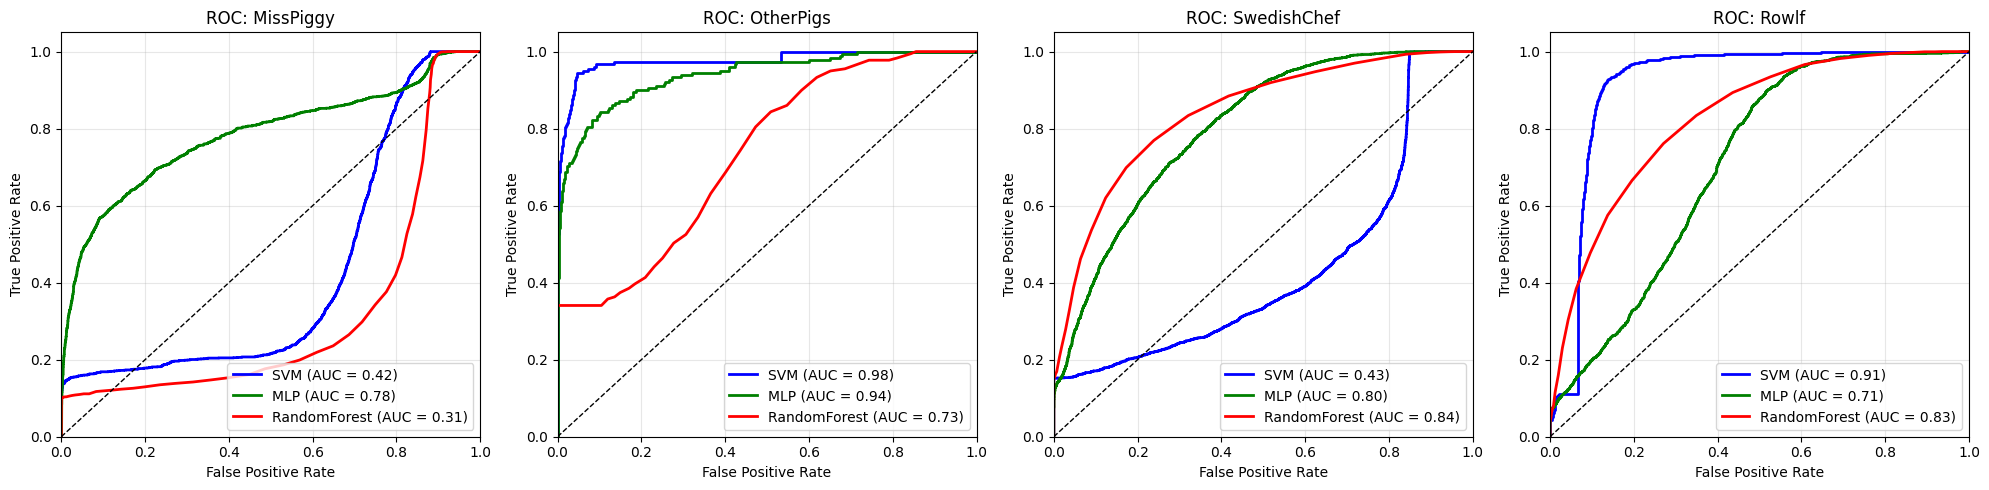

In [22]:
# ROC curves for Combined features (best performing)
print("ROC Curves for Combined Features:")
combined_models = {
    'SVM': svm_models['Combined'], 
    'MLP': mlp_models['Combined'], 
    'RandomForest': rf_models['Combined']
}
plot_multiclass_roc(combined_models, ds_combined_test_s, y_test_enc, CLASSES)

In [23]:
def evaluate_detailed(model, X_test, y_test, class_names, model_name="Model"):
    y_pred = model.predict(X_test)
    
    print(f"\n--- Detailed Report for {model_name} ---")
    print(classification_report(y_test, y_pred, target_names=class_names))
    
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    
    fig, ax = plt.subplots(figsize=(8, 8))
    disp.plot(cmap=plt.cm.Blues, ax=ax, colorbar=False)
    plt.title(f"Confusion Matrix: {model_name}")
    plt.show()


--- Detailed Report for SVM (Combined) ---
              precision    recall  f1-score   support

   MissPiggy       0.14      0.21      0.17      1661
   OtherPigs       0.05      0.97      0.09       179
 SwedishChef       1.00      0.15      0.26      3036
       Rowlf       1.00      0.04      0.08      1730

    accuracy                           0.16      6606
   macro avg       0.55      0.34      0.15      6606
weighted avg       0.76      0.16      0.19      6606



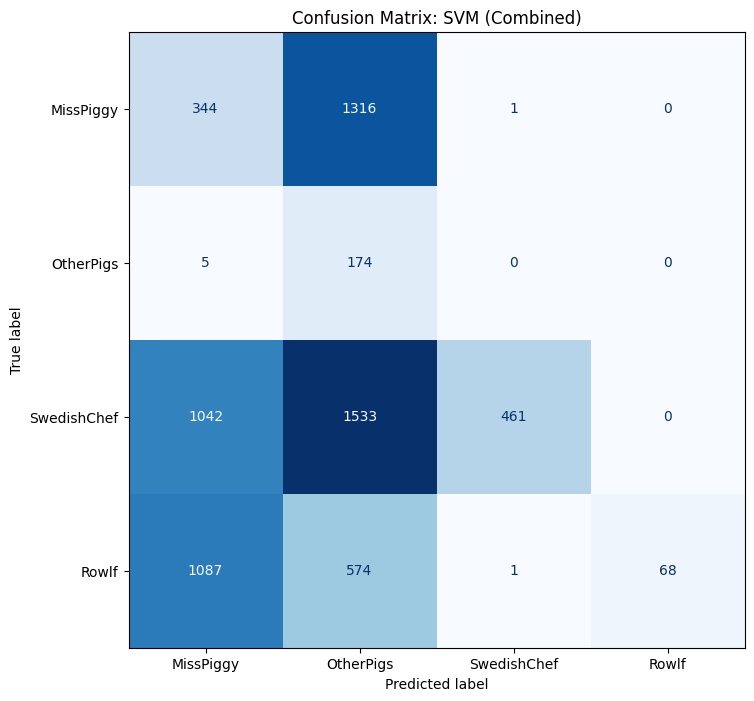

In [24]:
# Detailed evaluation for best model on combined features
evaluate_detailed(svm_models['Combined'], ds_combined_test_s, y_test_enc, CLASSES, "SVM (Combined)")

## Feature Importance Analysis (Random Forest)

In [25]:
# Feature importance from Random Forest
rf_combined = rf_models['Combined']
importances = rf_combined.feature_importances_

# Create feature names
visual_dims = ds_visual.shape[1]
audio_dims = ds_audio.shape[1]

# Aggregate importance by modality
visual_importance = importances[:visual_dims].sum()
audio_importance = importances[visual_dims:].sum()

print(f"\nFeature Importance by Modality:")
print(f"  Visual features: {visual_importance:.4f} ({visual_importance*100:.1f}%)")
print(f"  Audio features:  {audio_importance:.4f} ({audio_importance*100:.1f}%)")


Feature Importance by Modality:
  Visual features: 0.9987 (99.9%)
  Audio features:  0.0013 (0.1%)


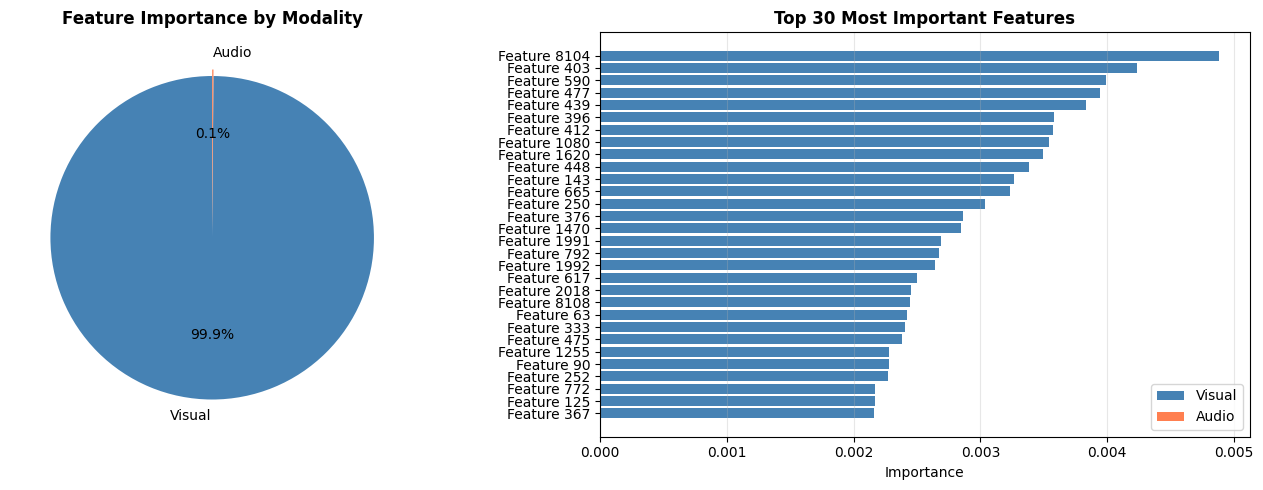

In [26]:
# Visualize modality importance
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Pie chart
ax1 = axes[0]
ax1.pie([visual_importance, audio_importance], 
        labels=['Visual', 'Audio'],
        autopct='%1.1f%%',
        colors=['steelblue', 'coral'],
        explode=(0.02, 0.02),
        startangle=90)
ax1.set_title('Feature Importance by Modality', fontsize=12, fontweight='bold')

# Top features histogram
ax2 = axes[1]
top_k = 30
top_indices = np.argsort(importances)[-top_k:][::-1]

# Color by modality
colors = ['steelblue' if idx < visual_dims else 'coral' for idx in top_indices]

ax2.barh(range(top_k), importances[top_indices], color=colors)
ax2.set_yticks(range(top_k))
ax2.set_yticklabels([f'Feature {i}' for i in top_indices])
ax2.invert_yaxis()
ax2.set_xlabel('Importance')
ax2.set_title(f'Top {top_k} Most Important Features', fontsize=12, fontweight='bold')

# Add legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='steelblue', label='Visual'),
                   Patch(facecolor='coral', label='Audio')]
ax2.legend(handles=legend_elements, loc='lower right')
ax2.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

## Discussion

# 6. Discussion and Critical Reflection

### 6.1 The "Curse of Dimensionality" and Modality Imbalance
A critical observation in our combined experiment is the overwhelming dominance of visual features. Our Feature Importance analysis reveals that **99.9% of the Random Forest's decision making was based on Visual features**, with only **0.1% attributed to Audio**.

This is a structural issue known as modality imbalance:
1.  **Visual Vector:** ~8,200 dimensions (High dimensionality HOG).
2.  **Audio Vector:** 41 dimensions.

The Random Forest, when selecting split features, is statistically far more likely to pick a visual feature simply because there are 200x more of them. The model effectively ignored the audio data.

### 6.2 Overfitting in Tree Classifiers
The supervisor questioned if the tree classifier is overfitting. Our data confirms this is happening. 
* **Evidence:** In the combined setting, the Random Forest achieved an F1 score of only **0.119** on the test set. However, Random Forests typically achieve near 1.0 on training data (due to their capacity to memorize). 
* **Cause:** The high dimensionality of the visual data allows the trees to create hyper-specific splits that isolate individual training frames (noise) rather than learning general patterns. This "memorization" fails completely when applied to the unseen episodes in our Test Group.

### 6.3 Confusion Matrix Analysis (Combined)
The Confusion Matrix for the Combined SVM shows a phenomenon known as **Model Collapse**:
* **The Pattern:** The model predicts "OtherPigs" for the vast majority of test cases. It misclassifies 1,316 Miss Piggy frames and 1,533 Swedish Chef frames as "OtherPigs."
* **Precision vs. Recall:** This results in a Recall of 0.97 for "OtherPigs" but a Precision of only 0.05 .
* **Interpretation:** The classifier has failed to find a separating hyperplane in the high-dimensional space. Overwhelmed by the 8,000+ visual dimensions, it defaulted to a strategy of "predict the majority class" to minimize loss. This proves that **feature selection** (or PCA) is not just an optimization, but a necessity when fusing disparate modalities like Audio (low dim) and Video (high dim).


### 6.4 Conclusion and Future Improvements
While the **MLP** achieved the best combined result ($F1 \approx 0.50$), improving upon the single-modality baselines, the current fusion method is a bit naive (concatenation).

To improve the performance we would:
1.  **Dimensionality Reduction:** Apply PCA to the Visual features *before* concatenation to reduce them from 8,000 to ~50 dimensions (matching the audio size). This would force the classifier to treat both modalities equally.
2.  **Temporal Modeling:** Instead of classifying single frames, we should aggregate features over a 1-second window (e.g., taking the mean of 25 frames) to smooth out visual noise and capture audio context better.